# Optimization of the CRM-like Box Beam with Distributed Load

In our [last notebook](20_Two-variables_Optimization_of_the_CRM-like_Box_Beam.ipynb) we performed a structural optimization employing two design variables. These design variables controlled the wall thickness at the root and at the tip of the box beam, which was assumed to vary linearly between the two prescribed locations. The optimization with the nonlinear structural stability constraint resulted in a 29% mass reduction with respect to the structure optimized with the traditional linear buckling constraint.

In this notebook we want to go a step further in complexity and perform the optimization with two design variables employing a distributed applied load. In order to obtain something that resembles an aerodynamic load, we consider an elliptical load distribution along the length of the box beam and we apply it in three different ways to study how the load application method affects the nonlinear stability response and the optimization results.

* [Definition of the box beam model](#model-definition)
* [Elliptical load applied with non-follower forces](#elliptical-load)
    * [Mesh convergence study](#mesh-convergence)
    * [Mesh convergence verification](#mesh-verification)
    * [Linear buckling optimization](#elliptical-load-linear)
    * [Nonlinear structural stability optimization](#elliptical-load-nonlinear)
* [Elliptical load applied on a load reference axis](#load-reference-axis)
    * [Linear buckling optimization](#load-reference-axis-linear)
    * [Nonlinear structural stability optimization](#load-reference-axis-nonlinear)
* [Elliptical load applied with follower forces](#follower-forces)
    * [Linear buckling optimization](#follower-forces-linear)
    * [Nonlinear structural stability optimization](#follower-forces-nonlinear)
* [Conclusion](#conclusion)

## Definition of the box beam model <a name="model-definition"></a>

***

We recall the geometrical parameters that we derived in [notebook 18](18_Development_and_Nonlinear_Buckling_Analysis_of_a_CRM-like_Box_Beam_Model.ipynb).

In [1]:
import numpy as np  # import numpy library

l = 29.38e3  # [mm] box beam length
w = 3.41e3  # [mm] box beam width
h = 0.77e3  # [mm] box beam height
t0 = h/100  # [mm] initial box beam thickness
stiffeners_height = h/10  # [mm] stiffeners height
no_stiffeners = 2  # number of stiffeners
stiffeners_x_locations = np.linspace(0, w, no_stiffeners + 2)[1:-1]  # [mm] stiffeners x-coordinates
stiffeners_spacing = w/(no_stiffeners + 1)  # [mm] stiffeners spacing
ribs_spacing = stiffeners_spacing*1.4 # [mm] ribs spacing
no_ribs = round(l/ribs_spacing) + 1  # number of ribs
ribs_y_locations = np.linspace(0, l, no_ribs)  # [mm] ribs y-coordinates
print(f"Number of stiffeners: {no_stiffeners:d}\nNumber of ribs: {no_ribs:d}")  # print number of stiffeners and ribs

Number of stiffeners: 2
Number of ribs: 19


We also recall the converged quadrilateral element length that we'll use to define our mesh.

In [2]:
element_length = 169.6  # [mm]

Then we recall the material properties, taken from the paper by [Brooks et al. (2018)](https://arc.aiaa.org/doi/10.2514/1.J056603).

In [3]:
rho = 2780e-12  # density [tons/mm^3]
E = 73.1e3  # Young's modulus [MPa]
nu = 0.3  # Poisson's ratio
SIGMA_Y = 420.  # yield strength [MPa]

## Elliptical load applied with non-follower forces <a name="elliptical-load"></a>

***

For the first analysis we consider an elliptical load applied by means of non-follower forces introduced at every node of the mesh. We will consider this approach as a baseline for the comparison with the other two load application methods.

We define the elliptical load distribution as

$$ P(y) = \frac{4}{\pi l}\sqrt{1 - \left(\frac{y}{l}\right)^2}\,,$$

where $l$ is the length of the box beam and $y$ is the coordinate along the beam axis. The factor $4/\left(\pi l\right)$ is introduced to ensure that total applied load is equal to $1$ N. In this way, we can easily scale the total applied load to any desired value.

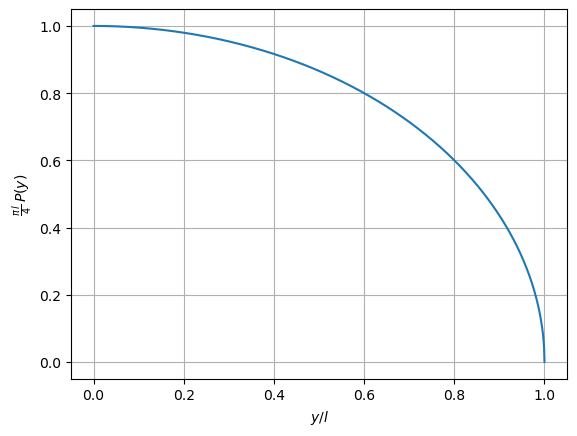

In [4]:
import matplotlib.pyplot as plt  # import matplotlib library

y_values = np.linspace(0, l, 1000)
load_distribution_values = (4 / (np.pi * l)) * np.sqrt(1 - (y_values / l)**2)
plt.plot(y_values/l, load_distribution_values/(4/(np.pi*l)))
plt.xlabel("$y/l$")
plt.ylabel(r"$\frac{\pi\,l}{4}\,P(y)$")
plt.grid(True)
plt.show()

To mimic an aerodynamic load, we are going to apply half of this load distribution to the top skin and the other half to the bottom skin of the box beam. In addition, for each $y$ coordinate along the box beam axis, we are going to distribute the load equally among the corresponding nodes of the top and bottom skins.

This type of load is different from the one that we applied in the previous analyses and optimizations of the CRM-like box beam and for this reason we need to perform a new mesh convergence study. For this reason we need a function that given a certain `BDF` object as input adds the appropriate `FORCE` cards to each node of the top skin and bottom skin of the box beam.

However, when we discretize our box beam into a mesh and we apply the forces to the nodes, the factor $4/\left(\pi l\right)$ does not ensure that the total applied load is equal to $1$ N, as the total applied load becomes a function of the number of nodes that we use to discretize the box beam. For this reason, we need to change the factor $4/\left(\pi l\right)$ depending on the mesh that we use.

To achieve the above, we define the function `apply_non_follower_elliptical_load`, which performs the following operations:
- finds the sequence of y-coordinate of the nodes of the box beam;
- finds the correct scaling factor to have a total applied load equal to $1$ N by finding the root of the function $f\left(n\right) = \sum_{i=1}^{n} P\left(y_i\right) - 1$, where $n$ is the number of nodes along the box beam axis and $P\left(y_i\right)$ is the load applied at the $i$-th station calculated with the elliptical load distribution formula introduced above;
- applies the forces to the nodes of the top and bottom skins of the box beam.

In [5]:
from scipy.optimize import fsolve  # import fsolve from scipy library
from resources import pynastran_utils  # import pynastran_utils module from resources folder

FORCE_SET_ID = 11  # set id for force cards

def apply_non_follower_elliptical_load(bdf_input):
    # Find list of node ids and array of node coordinates
    node_ids = []
    nodes_xyz_list = []
    for id in bdf_input.nodes.keys():
        node_ids.append(id)
        nodes_xyz_list.append(bdf_input.nodes[id].xyz)
    node_ids = np.array(node_ids)
    nodes_xyz_array = np.vstack(nodes_xyz_list)
    # Find unique y-coordinates within a tolerance of 1e-3 [mm]
    y_coordinates = np.unique(nodes_xyz_array[:, 1].round(decimals=3))
    # Find the scaling factor that makes the total applied load equal to 1
    f = lambda x: np.sum(x * np.sqrt(1 - (y_coordinates / l)**2)) - 1  # function to be solved to find the correct scaling factor
    scaling_factor_guess = 4 / (np.pi * l)  # initial guess for the solver
    scaling_factor = fsolve(f, scaling_factor_guess)[0]  # find the root of the function to find the scaling factor
    # Apply distributed load over top and bottom skin
    tol = 1e-3  # tolerance to find nodes at specific y and z coordinates [mm]
    for y in y_coordinates:  # loop over all y-coordinates
        top_skin_ids = node_ids[(np.abs(nodes_xyz_array[:, 1] - y) < tol) & (np.abs(nodes_xyz_array[:, 2] - h/2) < tol)]  # find id of nodes with y = y and z = h/2 (top skin nodes at current y-coordinate)
        local_force_magnitude = scaling_factor/2 * np.sqrt(1 - (y / l)**2)  # compute force magnitude at current y-coordinate (scaling factor is divided by 2 because the force is applied over both top and bottom skin)
        pynastran_utils.add_uniform_force(bdf_object=bdf_input, nodes_ids=top_skin_ids, set_id=FORCE_SET_ID,
                                          direction_vector=[0, 0, 1], force_magnitude=local_force_magnitude)  # apply local force over top skin nodes of current y-coordinate
        bottom_skin_ids = node_ids[(np.abs(nodes_xyz_array[:, 1] - y) < tol) & (np.abs(nodes_xyz_array[:, 2] + h/2) < tol)]  # find id of nodes with y = y and z = -h/2 (bottom skin nodes at current y-coordinate)
        pynastran_utils.add_uniform_force(bdf_object=bdf_input, nodes_ids=bottom_skin_ids, set_id=FORCE_SET_ID,
                                          direction_vector=[0, 0, 1], force_magnitude=local_force_magnitude)  # apply local force over bottom skin nodes of current y-coordinate
    

### Mesh convergence study <a name="mesh-convergence"></a>

In [6]:
%matplotlib widget

import os
from resources import box_beam_utils  # import box_beam_utils module from resources folder

plt.rcParams["figure.dpi"] = 120  # set default dpi of figures
eigenvalue_calculation_subcase_id = 2  # define subcase id of eigenvalue calculation

# Define shell elements' lengths to be used for the mesh convergence study and print them to screen
shell_element_lengths = np.geomspace(h/2, stiffeners_height/8, 10) # [m]
# shell_element_lengths = [shell_element_lengths[2]]
np.set_printoptions(precision=1, suppress=True)
print("Prescribed length of shell elements for mesh convergence study [mm]:")
print(shell_element_lengths)

# Initialize arrays with number of elements, number of degrees of freedom and linear buckling loads
no_elements = np.empty(np.shape(shell_element_lengths), dtype=int)
dofs = np.empty(np.shape(shell_element_lengths), dtype=int)
linear_buckling_loads = np.empty(np.shape(shell_element_lengths))

# Define name of analysis directory and of input file
analysis_directory_name = "21_Optimization_of_the_CRM-like_Box_Beam_with_Distributed_Load"
ANALYSIS_DIRECTORY_PATH = os.path.join(os.getcwd(), "analyses", analysis_directory_name)

# Define function to adjust axes ticks and labels' position
def adjust_3d_plot(axes, colorbar=None):
    axes.locator_params(axis="x", nbins=3)  # set number of ticks of x-axis
    axes.locator_params(axis="z", nbins=2)  # set number of ticks of z-axis
    axes.tick_params(axis="y", which="major", pad=20)  # adjust position of ticks' label of y-axis
    axes.tick_params(axis="z", which="major", pad=6)  # adjust position of ticks' label of z-axis
    axes.yaxis.labelpad = 70  # adjust position of y-axis's label
    axes.zaxis.labelpad = 10  # adjust position of z-axis's label
    if colorbar is not None:
        colorbar.ax.set_position(colorbar.ax.get_position().shrunk(1.0, .66))  # decrease colorbar size
        colorbar.ax.set_position(colorbar.ax.get_position().translated(-.05, .14))  # move colorbar upwards

# Iterate through the different edge lengths
for count, element_length in enumerate(shell_element_lengths):
    # Generate base bdf input
    box_beam_mesh = box_beam_utils.mesh_stiffened_box_beam_with_pyvista(width=w, height=h,
                                                                        ribs_y_coordinates=ribs_y_locations,
                                                                        stiffeners_x_coordinates=stiffeners_x_locations,
                                                                        stiffeners_height=stiffeners_height,
                                                                        element_length=element_length)
    nodes_xyz_array = box_beam_mesh.points
    nodes_connectivity_matrix = box_beam_mesh.faces.reshape(-1, 5)[:, 1:]
    linear_buckling_bdf = box_beam_utils.create_base_bdf_input(young_modulus=E, poisson_ratio=nu, density=rho,
                                                               shell_thickness=t0, nodes_xyz_array=nodes_xyz_array,
                                                               nodes_connectivity_matrix=nodes_connectivity_matrix)
    # Apply concetrated load at the tip
    apply_non_follower_elliptical_load(linear_buckling_bdf)
    # Store number of elements and number of degrees of freedom of current model
    no_elements[count] = len(linear_buckling_bdf.elements)
    constrained_nodes_ids = next(iter(linear_buckling_bdf.spcs.values()))[0].node_ids
    dofs[count] = (len(linear_buckling_bdf.nodes) - len(constrained_nodes_ids))*6
    # Run SOL 105 and return OP2 object
    input_name = f"linear_buckling_{no_elements[count]}_elements"
    sol_105_op2 = pynastran_utils.run_sol_105_buckling_analysis(bdf_object=linear_buckling_bdf,
                                                                static_load_set_id=FORCE_SET_ID,
                                                                analysis_directory_path=ANALYSIS_DIRECTORY_PATH,
                                                                input_name=input_name, run_flag=True)
    # Find critical buckling load and print it
    print(f"""\n\033[1mResults of model with:
    - {element_length:.1f} mm prescribed element length
    - {no_elements[count]:d} elements
    - {dofs[count]:d} degrees of freedom\033[0m""")
    linear_buckling_loads[count] = sol_105_op2.eigenvectors[eigenvalue_calculation_subcase_id].eigr
    print(f"Buckling load: {linear_buckling_loads[count]:.0f} N")
    # Plot critical buckling mode
    # print("Buckling mode:")
    # _, ax, cbar = pynastran_utils.plot_buckling_mode(op2_object=sol_105_op2, subcase_id=eigenvalue_calculation_subcase_id,
    #                                                  displacement_component='tz', colormap='sunset',
    #                                                  length_unit='m', displacement_amplification_factor=2, unit_scale_factor=1e-3)
    # adjust_3d_plot(ax, cbar)
    # plt.show()

Prescribed length of shell elements for mesh convergence study [mm]:
[385.  255.5 169.6 112.6  74.7  49.6  32.9  21.8  14.5   9.6]


subcase=0 already exists...skipping
c:\Users\qa21944\Anaconda3\envs\phd-notebooks\lib\site-packages\scipy\optimize\_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Nastran job linear_buckling_4344_elements.bdf completed
Wall time: 2.0 s



Results of model with:
    - 385.0 mm prescribed element length
    - 4344 elements
    - 24516 degrees of freedom
Buckling load: 32892 N


subcase=0 already exists...skipping


Nastran job linear_buckling_8856_elements.bdf completed
Wall time: 4.0 s



Results of model with:
    - 255.5 mm prescribed element length
    - 8856 elements
    - 50436 degrees of freedom
Buckling load: 31228 N


subcase=0 already exists...skipping


Nastran job linear_buckling_14976_elements.bdf completed
Wall time: 6.0 s



Results of model with:
    - 169.6 mm prescribed element length
    - 14976 elements
    - 85860 degrees of freedom
Buckling load: 30739 N


subcase=0 already exists...skipping


Nastran job linear_buckling_33120_elements.bdf completed
Wall time: 20.0 s



Results of model with:
    - 112.6 mm prescribed element length
    - 33120 elements
    - 192348 degrees of freedom
Buckling load: 30438 N


subcase=0 already exists...skipping


Nastran job linear_buckling_61632_elements.bdf completed
Wall time: 33.0 s



Results of model with:
    - 74.7 mm prescribed element length
    - 61632 elements
    - 359964 degrees of freedom
Buckling load: 30391 N


subcase=0 already exists...skipping


Nastran job linear_buckling_134496_elements.bdf completed
Wall time: 88.0 s



Results of model with:
    - 49.6 mm prescribed element length
    - 134496 elements
    - 790668 degrees of freedom
Buckling load: 30378 N


subcase=0 already exists...skipping


Nastran job linear_buckling_301248_elements.bdf completed
Wall time: 311.0 s



Results of model with:
    - 32.9 mm prescribed element length
    - 301248 elements
    - 1777788 degrees of freedom
Buckling load: 30358 N


subcase=0 already exists...skipping


Nastran job linear_buckling_674424_elements.bdf completed
Wall time: 1929.0 s



Results of model with:
    - 21.8 mm prescribed element length
    - 674424 elements
    - 3990276 degrees of freedom
Buckling load: 30366 N


subcase=0 already exists...skipping


Nastran job linear_buckling_1502064_elements.bdf completed
Wall time: 4743.0 s



Results of model with:
    - 14.5 mm prescribed element length
    - 1502064 elements
    - 8902980 degrees of freedom
Buckling load: 30361 N


subcase=0 already exists...skipping


Nastran job linear_buckling_3337920_elements.bdf completed
Wall time: 25481.0 s



Results of model with:
    - 9.6 mm prescribed element length
    - 3337920 elements
    - 19803852 degrees of freedom
Buckling load: 30378 N


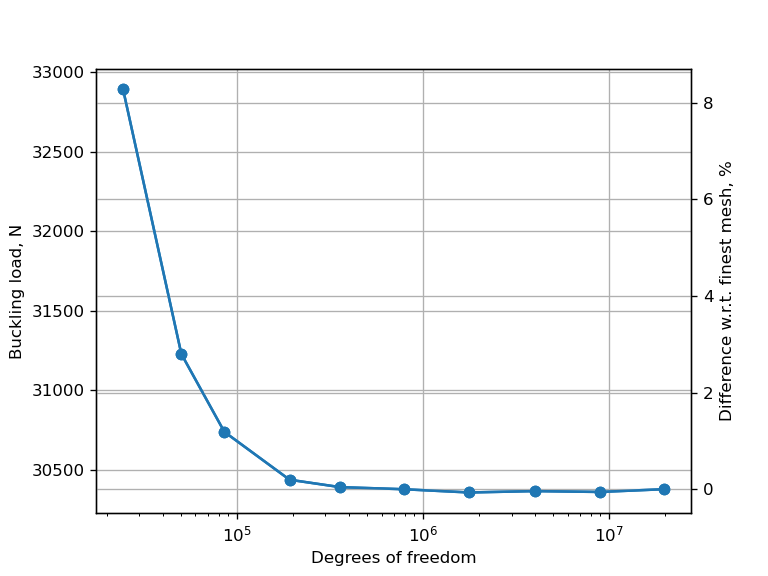

In [7]:
# Plot buckling loads vs degrees of freedom with a log scale along the x-axis
fig, ax1 = plt.subplots()  # create a figure and set of axes
buckling_load_line = ax1.semilogx(dofs, linear_buckling_loads, 'o-')

# Create a twin set of axes to plot percentage difference vs degrees of freedom
ax2 = ax1.twinx()
percentage_diff = (linear_buckling_loads/linear_buckling_loads[-1]-1)*100
percentage_diff_line = ax2.plot(dofs, percentage_diff, 'o-')

# Set plot appearance
ax1.set_xlabel('Degrees of freedom')
ax1.set_ylabel('Buckling load, N') #, color=buckling_load_line[0].get_color())
ax2.set_ylabel('Difference w.r.t. finest mesh, %') #, color=percentage_diff_line[0].get_color())
ax1.grid(True)
ax2.grid(True)
plt.show()

In [8]:
converged_mesh_index = np.where(np.abs(percentage_diff) < 1)[0][0]  # find index corresponding to first percentage difference below 1
element_length_converged_mesh = np.round(shell_element_lengths[converged_mesh_index], 1)  # store shell length of converged mesh
no_elements_converged_mesh = no_elements[converged_mesh_index]  # store number of elements of converged mesh
sol_105_buckling_load = np.round(linear_buckling_loads[converged_mesh_index])  # store buckling load of converged mesh approximating to the nearest integer
print(f"""
The mesh is converged for a target shell element length of {element_length_converged_mesh:.1f} mm,
corresponidng to {no_elements_converged_mesh} elements, {dofs[converged_mesh_index]} degrees of freedom
and to a linear buckling load of {sol_105_buckling_load:.0f} N.""")


The mesh is converged for a target shell element length of 112.6 mm,
corresponidng to 33120 elements, 192348 degrees of freedom
and to a linear buckling load of 30438 N.


### Mesh convergence verification <a name="mesh-verification"></a>

Nonlinear analysis with converged element length

In [9]:
# Create mesh with converged target element length
box_beam_mesh = box_beam_utils.mesh_stiffened_box_beam_with_pyvista(width=w, height=h,
                                                                    ribs_y_coordinates=ribs_y_locations,
                                                                    stiffeners_x_coordinates=stiffeners_x_locations,
                                                                    stiffeners_height=stiffeners_height,
                                                                    element_length=element_length_converged_mesh)

# Create BDF obejct and apply concentrated load at the tip
box_beam_bdf = box_beam_utils.create_base_bdf_input(E, nu, rho, t0, box_beam_mesh.points,
                                                    box_beam_mesh.faces.reshape(-1, 5)[:, 1:], parallel=True)
apply_non_follower_elliptical_load(box_beam_bdf)

# Setup SOL 106 with arc-length method using parameters for fine resolution of equilibrium path
fine_nlparm_id = 1  # id of NLPARM card with fine arc-length method parameters
pynastran_utils.set_up_arc_length_method(bdf_object=box_beam_bdf, max_iter=3, conv='PU', eps_p=1e-5, eps_u=1e-5, max_bisect=20,
                                         minalr=1e-5, desiter=3, maxinc=2000)

# Apply twice the buckling load
LOAD_SET_ID = FORCE_SET_ID + 1  # id of load set
FIRST_SUBCASE_ID = 1  # id of first subcase
scale_factor = sol_105_buckling_load*2  # scale factor to apply to the load set
box_beam_bdf.add_load(sid=LOAD_SET_ID, scale=1., scale_factors=[scale_factor], load_ids=[FORCE_SET_ID])  # add LOAD card
pynastran_utils.create_static_load_subcase(bdf_object=box_beam_bdf, subcase_id=FIRST_SUBCASE_ID, load_set_id=LOAD_SET_ID)  # create subcase with static load

# Run nonlinear analysis
METHOD_SET_ID = LOAD_SET_ID + 1
NO_EIGENVALUES = 20
UPPER_EIGENVALUE = 100.  # upper bound for eigenvalues [N/mm] - set to 10^5 N/m to avoid convergence issues of Lanczos solver
input_name_dict = {"original mesh": f"nonlinear_analysis_{no_elements_converged_mesh}_elements"}
sol_106_op2_original_mesh = pynastran_utils.run_tangent_stiffness_matrix_eigenvalue_calculation(
    bdf_object=box_beam_bdf.__deepcopy__({}), method_set_id=METHOD_SET_ID, no_eigenvalues=NO_EIGENVALUES,
    analysis_directory_path=ANALYSIS_DIRECTORY_PATH, input_name=input_name_dict["original mesh"], upper_eig=UPPER_EIGENVALUE,
    run_flag=True)

subcase=0 already exists...skipping


Nastran job nonlinear_analysis_33120_elements.bdf completed
Wall time: 9144.0 s


Find id of node where linear buckling predicts max displacement for model with converged mesh

In [10]:
from pyNastran.op2.op2 import read_op2  # import function to read op2 file

# Read op2 file of linear buckling analysis
input_name = f"linear_buckling_{no_elements_converged_mesh}_elements"
sol_105_op2_filepath = os.path.join(ANALYSIS_DIRECTORY_PATH, input_name + '.op2')
sol_105_op2 = read_op2(op2_filename=sol_105_op2_filepath, load_geometry=True, debug=None)

# Find node where max displacement occurs
max_displacement_index = np.argmax(np.linalg.norm(sol_105_op2.eigenvectors[eigenvalue_calculation_subcase_id].data[
    0, :, 0:3], axis=1))  # find index of max displacement magnitude
max_displacement_node_id = sol_105_op2.eigenvectors[eigenvalue_calculation_subcase_id].node_gridtype[
    max_displacement_index, 0]

Create model with refined mesh

In [11]:
# Create mesh with half of the converged target element length
box_beam_refined_mesh = box_beam_utils.mesh_stiffened_box_beam_with_pyvista(
    width=w, height=h, ribs_y_coordinates=ribs_y_locations, stiffeners_x_coordinates=stiffeners_x_locations,
    stiffeners_height=stiffeners_height, element_length=element_length_converged_mesh/2)

# Create BDF object and apply concentrated load at the tip
refined_mesh_box_beam_bdf = box_beam_utils.create_base_bdf_input(E, nu, rho, t0, box_beam_refined_mesh.points,
                                                                 box_beam_refined_mesh.faces.reshape(-1, 5)[:, 1:], parallel=True)
apply_non_follower_elliptical_load(refined_mesh_box_beam_bdf)

subcase=0 already exists...skipping


Linear buckling analysis of model with refined mesh

In [12]:
# Run SOL 105 and return OP2 object
no_elements_refined_mesh = len(refined_mesh_box_beam_bdf.elements)
input_name = f"linear_buckling_{no_elements_refined_mesh}_elements"
sol_105_op2_refined_mesh = pynastran_utils.run_sol_105_buckling_analysis(
    bdf_object=refined_mesh_box_beam_bdf.__deepcopy__({}), static_load_set_id=FORCE_SET_ID,
    analysis_directory_path=ANALYSIS_DIRECTORY_PATH, input_name=input_name, run_flag=True)

# Find node where max displacement occurs
refined_mesh_max_displacement_index = np.argmax(np.linalg.norm(sol_105_op2_refined_mesh.eigenvectors[
    eigenvalue_calculation_subcase_id].data[0, :, 0:3], axis=1))  # find index of max displacement magnitude
refined_mesh_max_displacement_node_id = sol_105_op2_refined_mesh.eigenvectors[
    eigenvalue_calculation_subcase_id].node_gridtype[refined_mesh_max_displacement_index, 0]

Nastran job linear_buckling_108276_elements.bdf completed
Wall time: 50.0 s


Nonlinear analysis of model with refined mesh

In [13]:
# Create static load subcase with twice the buckling load predicted by SOL 105
refined_mesh_box_beam_bdf.add_load(sid=LOAD_SET_ID, scale=1., scale_factors=[scale_factor], load_ids=[FORCE_SET_ID])
pynastran_utils.create_static_load_subcase(bdf_object=refined_mesh_box_beam_bdf, subcase_id=FIRST_SUBCASE_ID,
                                           load_set_id=LOAD_SET_ID)

# Setup SOL 106 with arc-length method using parameters for fine resolution of equilibrium path
pynastran_utils.set_up_arc_length_method(bdf_object=refined_mesh_box_beam_bdf, max_iter=3, conv='PU', eps_p=1e-5, eps_u=1e-5, max_bisect=20,
                                         minalr=1e-5, desiter=3, maxinc=2000)

# Run analysis
input_name_dict["refined mesh"] = f"nonlinear_analysis_{no_elements_refined_mesh}_elements"
sol_106_op2_refined_mesh = pynastran_utils.run_tangent_stiffness_matrix_eigenvalue_calculation(
    bdf_object=refined_mesh_box_beam_bdf.__deepcopy__({}), method_set_id=METHOD_SET_ID, no_eigenvalues=NO_EIGENVALUES,
    analysis_directory_path=ANALYSIS_DIRECTORY_PATH, input_name=input_name_dict["refined mesh"], upper_eig=UPPER_EIGENVALUE, run_flag=True)

Nastran job nonlinear_analysis_108276_elements.bdf completed
Wall time: 83988.0 s


Find nondimensional displacements and applied loads of both models

In [14]:
# Read tip and local displacements of the original mesh
local_displacements = {}
tip_displacements = {}
applied_loads = {}
tip_point_xyz = np.array([w/2, l, 0])
tip_node_id = np.argmin(np.linalg.norm(box_beam_mesh.points - tip_point_xyz, axis=1)) + 1
_, _, local_displacements["original mesh"] = pynastran_utils.read_load_displacement_history_from_op2(
    op2_object=sol_106_op2_original_mesh, displacement_node_id=max_displacement_node_id)
_, applied_loads["original mesh"], tip_displacements["original mesh"] = pynastran_utils.read_load_displacement_history_from_op2(
    op2_object=sol_106_op2_original_mesh, displacement_node_id=tip_node_id)

# Read tip and local displacements of the refined mesh
refined_mesh_tip_node_id = np.argmin(np.linalg.norm(box_beam_refined_mesh.points - tip_point_xyz, axis=1)) + 1
_, _, local_displacements["refined mesh"] = pynastran_utils.read_load_displacement_history_from_op2(
    op2_object=sol_106_op2_refined_mesh, displacement_node_id=refined_mesh_max_displacement_node_id)
_, applied_loads["refined mesh"], tip_displacements["refined mesh"] = pynastran_utils.read_load_displacement_history_from_op2(
    op2_object=sol_106_op2_refined_mesh, displacement_node_id=refined_mesh_tip_node_id)
    
# Create dictionaries with nondimensional tip displacements and applied loads
Z_AXIS_INDEX = 2
nondimensional_local_displacements = {key: local_displacements[key][FIRST_SUBCASE_ID][:, Z_AXIS_INDEX]/w
                                      for key in local_displacements}
nondimensional_tip_displacements = {key: tip_displacements[key][FIRST_SUBCASE_ID][:, Z_AXIS_INDEX]/l
                                    for key in tip_displacements}
nondimensional_applied_loads = {key: applied_loads[key][FIRST_SUBCASE_ID][:, Z_AXIS_INDEX]/sol_105_buckling_load
                                for key in applied_loads}

Plot 3D equlibrium paths

In [15]:
import tol_colors as tc  # package for colorblind-friendly colors
from matplotlib.lines import Line2D  # class defining the characters for the marker styles

plt.rc('axes', prop_cycle=plt.cycler('color', list(tc.tol_cset('bright'))))  # set default color cycle to TOL bright
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']  # list with default color cycle
markers = list(Line2D.markers.keys())[2:]  # list of marker characters
UNSTABLE_COLOR = colors[1]  # set red color for unstable segments
GLASS_CEILING_COLOR = colors[2]  # set green color for glass ceiling
del colors[1:3]  # remove red and green colors from list of colors

# Define function to plot 3D load-displacement diagram segment by segment
def plot_3d_segments(eigvals, axes, local_disp, tip_disp, loads, marker, color):
    negative_eigenvalues_mask = (eigvals < 0).any(axis=0)
    unstable_segments = []  # list to store indices of unstable segments
    stable_segments = []  # list to store indices of stable segments
    # Loop through the negative_eigenvalues_mask to identify and plot segments
    for i, is_negative in enumerate(negative_eigenvalues_mask):
        if is_negative:
            if stable_segments:
                # Plot the stable segment if there was one before
                stable_segments.append(i)  # make the stable segment finish at the first point of the unstable segment
                axes.plot3D(local_disp[stable_segments], tip_disp[stable_segments], loads[stable_segments], marker + '-', color=color)
                stable_segments = []  # reset the stable segment indices
            unstable_segments.append(i)  # add the current index to the unstable segment, this will overwrite the blue point with a red one
        else:
            if unstable_segments:
                # Plot the unstable segment if there was one before
                unstable_segments.append(i)  # make the unstable segment finish at the first point of the stable segment
                axes.plot3D(local_disp[unstable_segments], tip_disp[unstable_segments], loads[unstable_segments],  marker + '--',
                            color=UNSTABLE_COLOR)
                unstable_segments = []  # reset the unstable segment indices
            stable_segments.append(i)  # add the current index to the stable segment, this will overwrite the red point with a blue one
    # Plot the remaining segments if any
    if stable_segments:
        axes.plot3D(local_disp[stable_segments], tip_disp[stable_segments], loads[stable_segments], marker + '-', color=color)
    if unstable_segments:
        axes.plot3D(local_disp[unstable_segments], tip_disp[unstable_segments], loads[unstable_segments], marker + "--", color=UNSTABLE_COLOR)


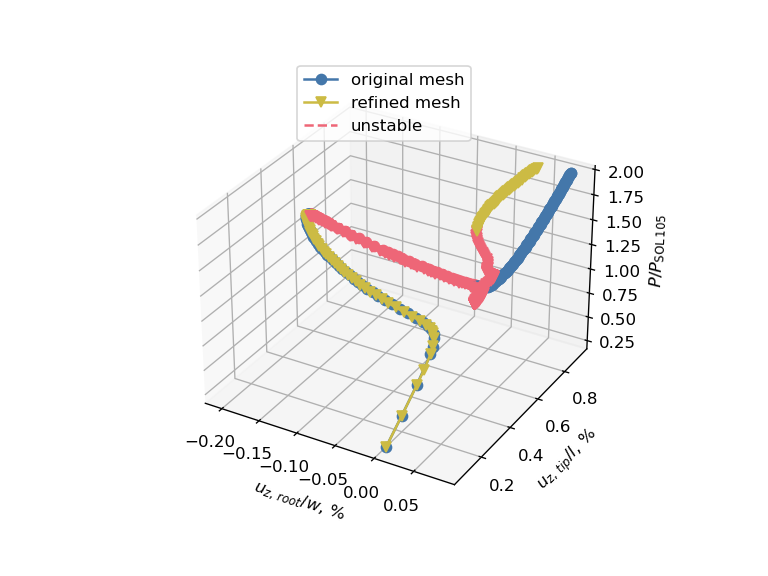

In [16]:
# Create 3D plot of equilibrium diagram
fig = plt.figure()
ax_3d = plt.axes(projection="3d")
eigenvalues_dict = {}
stable_lines = []  # list to store proxy artists for the legend
for count, key in enumerate(nondimensional_local_displacements):
    # Read eigenvalues obtained with refence mesh
    f06_path = os.path.join(ANALYSIS_DIRECTORY_PATH, input_name_dict[key] + '.f06')  # path to .f06 file
    eigenvalues_dict[key] = pynastran_utils.read_kllrh_lowest_eigenvalues_from_f06(f06_path)
    # Plot equilibrium diagram
    plot_3d_segments(eigenvalues_dict[key], ax_3d, nondimensional_local_displacements[key]*100,
                     nondimensional_tip_displacements[key]*100,
                     nondimensional_applied_loads[key], markers[count], colors[count])
    stable_lines.append(Line2D([0], [0], linestyle='-', marker=markers[count], color=colors[count], label=key))  # create proxy artist for the legend

# Add proxy artist for unstable lines and create legend
unstable_line = Line2D([0], [0], linestyle='--', color=UNSTABLE_COLOR, label="unstable")
fig.legend(handles=stable_lines + [unstable_line], loc="upper center", bbox_to_anchor=(0.5, 0.9))

# Set plot appearance
ax_3d.set_xlabel("$u_{z,\,root}/w$, %")
ax_3d.set_ylabel("$u_{z,\,tip}/l$, %")
ax_3d.set_zlabel("$P/P_\mathrm{SOL\/105}$")
ax_3d.grid(visible=True)
plt.show()

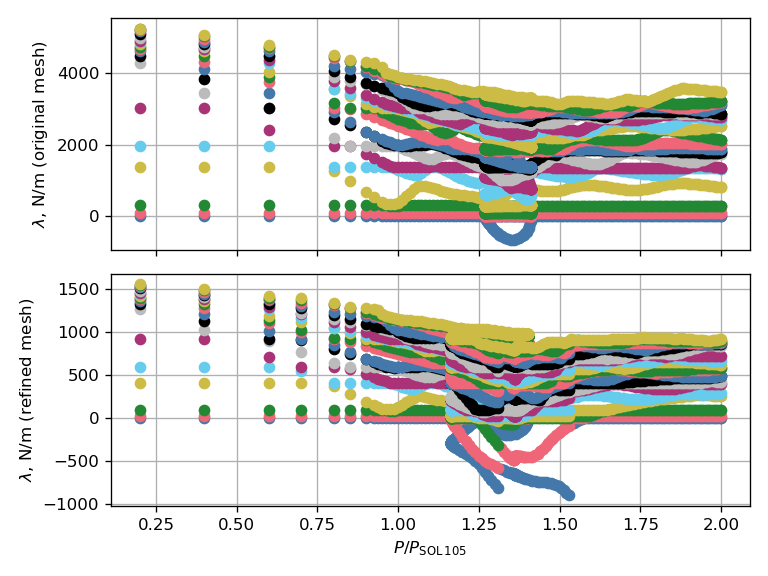

In [17]:
# Create the figure and subplots
fig, axes = plt.subplots(2, 1, sharex=True)
nondimensional_limit_point_loads = {}
for count, key in enumerate(input_name_dict):
    # Find applied load at limit point
    first_negative_eigenvalue_index = np.where(eigenvalues_dict[key][0, :] < 0)[0][0]  # find index of first negative eigenvalue
    nondimensional_limit_point_loads[key] = np.mean(nondimensional_applied_loads[key][
        first_negative_eigenvalue_index - 1:first_negative_eigenvalue_index + 1])  # calculate applied load at limit point as the mean of the applied loads between positive and negative eigenvalue

    # Plot for refence mesh
    axes[count].plot(nondimensional_applied_loads[key], eigenvalues_dict[key].T*1e3, 'o')  # convert eigenvalues from N/mm to N/m
    axes[count].set_ylabel(f"$\lambda$, N/m ({key})")
    axes[count].grid(True)

# Finalize plot appearance
axes[count].set_xlabel("$P/P_\mathrm{SOL\/105}$")
plt.tight_layout()
plt.show()

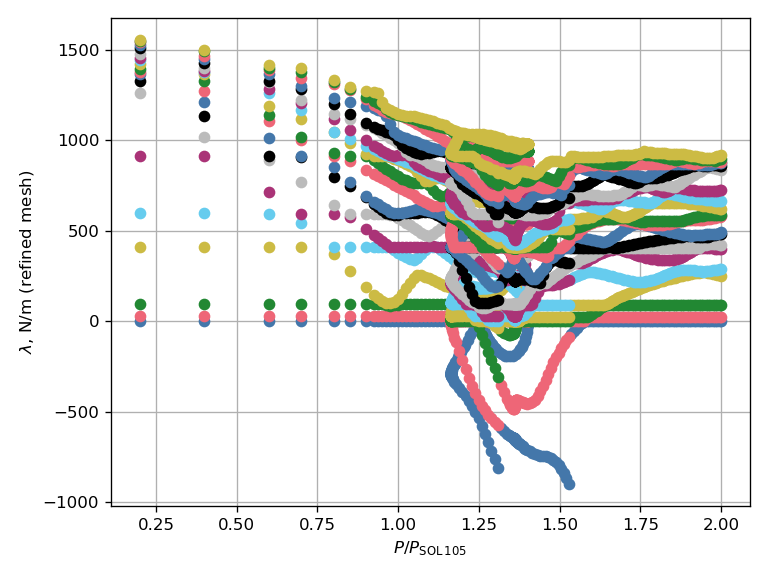

In [18]:
fig, ax = plt.subplots()
# Plot for refence mesh
ax.plot(nondimensional_applied_loads[key], eigenvalues_dict[key].T*1e3, 'o')  # convert eigenvalues from N/mm to N/m
ax.set_ylabel(f"$\lambda$, N/m ({key})")
ax.grid(True)

# Finalize plot appearance
ax.set_xlabel("$P/P_\mathrm{SOL\/105}$")
plt.tight_layout()
plt.show()

The mesh is converged also in the nonlienar regime, however it might be too expensive for the optimization. For this reason, we run a nonlinear analysis with a mesh having as target element length twice the converged element length and we compare the results shown above.

subcase=0 already exists...skipping


Nastran job linear_buckling_5232_elements.bdf completed
Wall time: 2.0 s


Nastran job nonlinear_analysis_5232_elements.bdf completed
Wall time: 1085.0 s


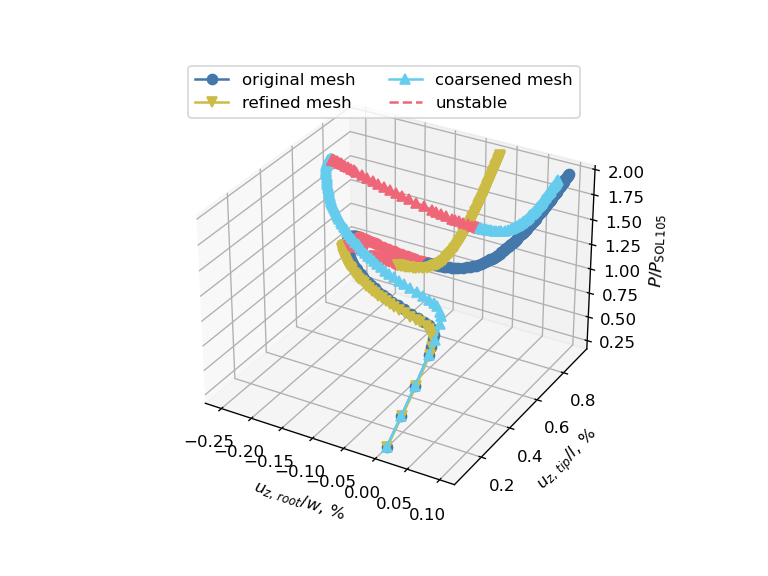

In [17]:
# Create mesh with twice the converged target element length
box_beam_coarsened_mesh = box_beam_utils.mesh_stiffened_box_beam_with_pyvista(
    width=w, height=h, ribs_y_coordinates=ribs_y_locations, stiffeners_x_coordinates=stiffeners_x_locations,
    stiffeners_height=stiffeners_height, element_length=element_length_converged_mesh*2)

# Create BDF object and apply concentrated load at the tip
coarsened_mesh_box_beam_bdf = box_beam_utils.create_base_bdf_input(E, nu, rho, t0, box_beam_coarsened_mesh.points,
                                                                   box_beam_coarsened_mesh.faces.reshape(-1, 5)[:, 1:], parallel=True)
apply_non_follower_elliptical_load(coarsened_mesh_box_beam_bdf)

# Run SOL 105 and return OP2 object
no_elements_coarsened_mesh = len(coarsened_mesh_box_beam_bdf.elements)
input_name = f"linear_buckling_{no_elements_coarsened_mesh}_elements"
sol_105_op2_coarsened_mesh = pynastran_utils.run_sol_105_buckling_analysis(
    bdf_object=coarsened_mesh_box_beam_bdf.__deepcopy__({}), static_load_set_id=FORCE_SET_ID,
    analysis_directory_path=ANALYSIS_DIRECTORY_PATH, input_name=input_name, run_flag=True)

# Find node where max displacement occurs
coarsened_mesh_max_displacement_index = np.argmax(np.linalg.norm(sol_105_op2_coarsened_mesh.eigenvectors[
    eigenvalue_calculation_subcase_id].data[0, :, 0:3], axis=1))  # find index of max displacement magnitude
coarsened_mesh_max_displacement_node_id = sol_105_op2_coarsened_mesh.eigenvectors[
    eigenvalue_calculation_subcase_id].node_gridtype[coarsened_mesh_max_displacement_index, 0]

# Create static load subcase with twice the buckling load predicted by SOL 105
coarsened_mesh_box_beam_bdf.add_load(sid=LOAD_SET_ID, scale=1., scale_factors=[scale_factor], load_ids=[FORCE_SET_ID])
pynastran_utils.create_static_load_subcase(bdf_object=coarsened_mesh_box_beam_bdf, subcase_id=FIRST_SUBCASE_ID,
                                           load_set_id=LOAD_SET_ID)

# Setup SOL 106 with arc-length method using parameters for fine resolution of equilibrium path
pynastran_utils.set_up_arc_length_method(bdf_object=coarsened_mesh_box_beam_bdf, max_iter=3, conv='PU', eps_p=1e-5, eps_u=1e-5, max_bisect=20,
                                         minalr=1e-5, desiter=3, maxinc=1000)

# Run analysis
input_name_dict["coarsened mesh"] = f"nonlinear_analysis_{no_elements_coarsened_mesh}_elements"
sol_106_op2_coarsened_mesh = pynastran_utils.run_tangent_stiffness_matrix_eigenvalue_calculation(
    bdf_object=coarsened_mesh_box_beam_bdf.__deepcopy__({}), method_set_id=METHOD_SET_ID, no_eigenvalues=NO_EIGENVALUES,
    analysis_directory_path=ANALYSIS_DIRECTORY_PATH, input_name=input_name_dict["coarsened mesh"], upper_eig=UPPER_EIGENVALUE, run_flag=True)

# Calculate nondimensional displacements and applied loads
coarsened_mesh_tip_node_id = np.argmin(np.linalg.norm(box_beam_coarsened_mesh.points - tip_point_xyz, axis=1)) + 1
_, _, local_displacements["coarsened mesh"] = pynastran_utils.read_load_displacement_history_from_op2(
    op2_object=sol_106_op2_coarsened_mesh, displacement_node_id=coarsened_mesh_max_displacement_node_id)
nondimensional_local_displacements["coarsened mesh"] = local_displacements["coarsened mesh"][FIRST_SUBCASE_ID][:, Z_AXIS_INDEX]/w
_, applied_loads["coarsened mesh"], tip_displacements["coarsened mesh"] = pynastran_utils.read_load_displacement_history_from_op2(
    op2_object=sol_106_op2_coarsened_mesh, displacement_node_id=coarsened_mesh_tip_node_id)
nondimensional_tip_displacements["coarsened mesh"] = tip_displacements["coarsened mesh"][FIRST_SUBCASE_ID][:, Z_AXIS_INDEX]/l
nondimensional_applied_loads["coarsened mesh"] = applied_loads["coarsened mesh"][FIRST_SUBCASE_ID][:, Z_AXIS_INDEX]/sol_105_buckling_load
f06_path = os.path.join(ANALYSIS_DIRECTORY_PATH, input_name_dict["coarsened mesh"] + '.f06')  # path to .f06 file
eigenvalues_dict["coarsened mesh"] = pynastran_utils.read_kllrh_lowest_eigenvalues_from_f06(f06_path)

# Create 3D plot of equilibrium diagram
fig = plt.figure()
ax_3d = plt.axes(projection="3d")
stable_lines = []  # list to store Line2D objects for stable segments
for count, key in enumerate(nondimensional_local_displacements):
    plot_3d_segments(eigenvalues_dict[key], ax_3d, nondimensional_local_displacements[key]*100,
                     nondimensional_tip_displacements[key]*100,
                     nondimensional_applied_loads[key], markers[count], colors[count])
    stable_lines.append(Line2D([0], [0], linestyle='-', marker=markers[count], color=colors[count], label=key))  # create proxy artist for the legend

# Add proxy artist for unstable lines and create legend
unstable_line = Line2D([0], [0], linestyle='--', color=UNSTABLE_COLOR, label="unstable")
fig.legend(handles=stable_lines + [unstable_line], loc="upper center", bbox_to_anchor=(0.5, 0.9), ncols=2)

# Set plot appearance
ax_3d.set_xlabel("$u_{z,\,root}/w$, %")
ax_3d.set_ylabel("$u_{z,\,tip}/l$, %")
ax_3d.set_zlabel("$P/P_\mathrm{SOL\/105}$")
ax_3d.grid(visible=True)
plt.show()

Read eigenvalues of tangent stiffness matrix and plot

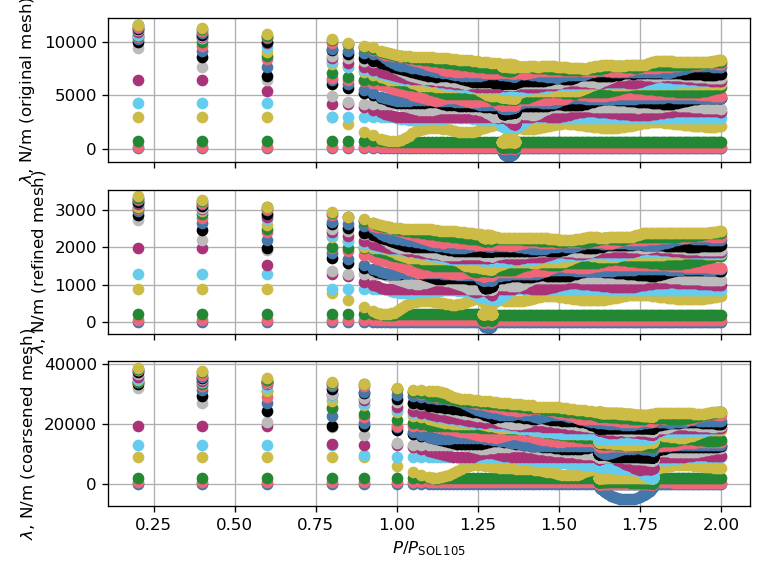

In [18]:
# Create the figure and subplots
fig, axes = plt.subplots(3, 1, sharex=True)
nondimensional_limit_point_loads = {}
for count, key in enumerate(input_name_dict):
    # Find applied load at limit point
    first_negative_eigenvalue_index = np.where(eigenvalues_dict[key][0, :] < 0)[0][0]  # find index of first negative eigenvalue
    nondimensional_limit_point_loads[key] = np.mean(nondimensional_applied_loads[key][
        first_negative_eigenvalue_index - 1:first_negative_eigenvalue_index + 1])  # calculate applied load at limit point as the mean of the applied loads between positive and negative eigenvalue

    # Plot for refence mesh
    axes[count].plot(nondimensional_applied_loads[key], eigenvalues_dict[key].T*1e3, 'o')  # convert eigenvalues from N/mm to N/m
    axes[count].set_ylabel(f"$\lambda$, N/m ({key})")
    axes[count].grid(True)

# Finalize plot appearance
axes[count].set_xlabel("$P/P_\mathrm{SOL\/105}$")
plt.tight_layout()
plt.show()

In [19]:
# Print nondimensional applied load at limit point
print("Nondimensional applied load at first limit point:")
for key in nondimensional_limit_point_loads:
    print(f"- {key}: {nondimensional_limit_point_loads[key]:.2f}")

# Print percentage difference of refined and coarsened mesh w.r.t. original mesh
print(f"""\nPercentage difference of nondimensional applied load at first limit point w.r.t. original mesh:
- refined mesh: {(nondimensional_limit_point_loads["refined mesh"]/nondimensional_limit_point_loads["original mesh"] - 1)*100:.1f} %
- coarsened mesh: {(nondimensional_limit_point_loads["coarsened mesh"]/nondimensional_limit_point_loads["original mesh"] - 1)*100:.1f} %
""")

Nondimensional applied load at first limit point:
- original mesh: 1.36
- refined mesh: 1.29
- coarsened mesh: 1.79

Percentage difference of nondimensional applied load at first limit point w.r.t. original mesh:
- refined mesh: -5.2 %
- coarsened mesh: 31.2 %



### Linear buckling optimization <a name="elliptical-load-linear"></a>

In [25]:
import openmdao.api as om  # make available the most common OpenMDAO classes and functions
from pyNastran.bdf.bdf import BDF  # pyNastran BDF class
from pyNastran.bdf.mesh_utils.mass_properties import mass_properties  # pyNastran function to calculate mass properties


SECOND_SUBCASE_ID = 2  # id of second subcase for SOL 106
SOL_105_INPUT_NAME = 'linear_opt_sol_105'  # default name of the bdf file for the analysis
 

class Sol105Comp(om.ExplicitComponent):
    """
    A component for evaluating the objective and constraints value of the box beam model using SOL 105.

    This component takes as input the wall thickness of the box beam and evaluates the mass of the model.
    It also calculates the value of the linear buckling and of the strength constraint.

    Attributes
    ----------
    options : dict
        A dictionary of options for the component.

    Methods
    -------
    initialize()
        Declare options for the component.
    setup()
        Define the component's inputs and outputs.
    setup_partials()
        Declare partial derivatives for the component.
    compute(inputs, outputs, discrete_inputs, discrete_outputs)
        Run SOL 106 and calculate output functions.
    compute_ks_function(g, rho=100, upper=0, lower_flag=False)
        Compute the value of the KS function for a given array of constraints.
    """

    def initialize(self):
        """
        Declare options for the component.

        Options
        -------
        bdf_object : BDF
            The BDF object representing the model.
        """
        self.options.declare("bdf_object", types=BDF)

    def setup(self):
        """
        Define the component's inputs and outputs.

        Inputs
        ------
        t : float
            Wall thickness.
        input_name : str, discrete
            Name of the input for the analysis.
        run_flag : bool, discrete
            Flag to indicate if the analysis should be run.

        Outputs
        -------
        mass : float
            Mass of the model.
        ks_stress : float
            Von Mises stress aggregated with KS function.
        ks_stability : float
            Lowest eigenvalues of the tangent stiffness matrix aggregated with KS function.
        applied_load : float
            Final applied load in the analysis.
        op2 : OP2, discrete
            OP2 object of the analysis.
        """
        self.add_input('t', shape_by_conn=True)
        self.add_discrete_input('input_name', val=SOL_105_INPUT_NAME)
        self.add_discrete_input('run_flag', val=True)
        self.add_output('mass')
        self.add_output('ks_stress')
        self.add_output('ks_buckling')
        self.add_discrete_output('op2', val=None)

    def setup_partials(self):
        """
        Declare partial derivatives for the component using finite difference method.
        """
        # Finite difference all partials
        self.declare_partials('*', '*', method='fd', step=1e-6)

    def compute(self, inputs, outputs, discrete_inputs, discrete_outputs):
        """
        Assign wall thickness value, run SOL 106 and calculate output functions.

        Parameters
        ----------
        inputs : dict
            Dictionary containing the input values.
        outputs : dict
            Dictionary containing the output values.
        discrete_inputs : dict
            Dictionary containing the discrete input values.
        discrete_outputs : dict
            Dictionary containing the discrete output values.
        """
        # Assign component options
        bdf_object = self.options['bdf_object']
        # Assign thicknesses to PSHELL cards
        for i, pid in enumerate(bdf_object.properties):
            bdf_object.properties[pid].t = inputs['t'][0, i]
            bdf_object.properties[pid].z1 = -inputs['t'][0, i]/2
            bdf_object.properties[pid].z2 = inputs['t'][0, i]/2
        # Calculate mass
        outputs['mass'] = mass_properties(bdf_object)[0]
        # Run SOL 105 and set OP2 object as discrete output
        input_name = discrete_inputs['input_name']
        run_flag = discrete_inputs['run_flag']
        sol_105_op2 = pynastran_utils.run_sol_105_buckling_analysis(
            bdf_object=bdf_object.__deepcopy__({}), static_load_set_id=LOAD_SET_ID,
            analysis_directory_path=ANALYSIS_DIRECTORY_PATH, input_name=input_name,
            no_eigenvalues=NO_EIGENVALUES, run_flag=run_flag)
        discrete_outputs['op2'] = sol_105_op2
        # Read buckling load factors and aggregate with KS function
        outputs['ks_buckling'] = self.compute_ks_function(np.array(sol_105_op2.eigenvectors[SECOND_SUBCASE_ID].eigrs),
                                                          lower_flag=True, upper=1.)
        # Find von mises stresses and aggregate with KS function
        stresses = sol_105_op2.cquad4_stress[FIRST_SUBCASE_ID].data[0, :, 7]
        outputs['ks_stress'] = self.compute_ks_function(stresses, upper=SIGMA_Y)
    
    @staticmethod
    def compute_ks_function(g, rho=100, upper=0, lower_flag=False):
        """
        Compute the value of the KS function for the given array of constraints.

        Parameters
        ----------
        g : ndarray
            Array of constraint values. By default negative means satisfied and positive means violated. Behavior is modified with upper and lower_flag.
        rho : float, optional
            Constraint aggregation factor. Default is 100.
        upper : float, optional
            Upper bound for the constraints. If lower_flag is True, then this is the lower bound. Default is 0.
        lower_flag : bool, optional
            Flag to indicate if the constraints are lower-bounded. Default is False.

        Returns
        -------
        float
            Value of KS function.
        """
        con_val = g - upper  # subtract upper bound
        if lower_flag:
            con_val = -con_val  # negate if constraint is lower-bounded
        g_max = np.max(np.atleast_2d(con_val), axis=-1)[:, np.newaxis]  # find maximum constraint value
        g_diff = con_val - g_max  # subtract maximum constraint value
        exponents = np.exp(rho * g_diff)  # exponentiate
        summation = np.sum(exponents, axis=-1)[:, np.newaxis]  # sum exponentiated values
        KS = g_max + 1.0 / rho * np.log(summation)  # compute KS function
        return KS

In [26]:
class BoxBeamLinearGroup(om.Group):
    """
    A group representing a system setup for the linear buckling analysis and optimization of a box beam model.

    This group is designed for the analysis and the mass minimization of a box beam model, 
    subject to KS aggregated von Mises stress and linear buckling constraints. 
    It incorporates the Sol105Comp component to achieve this.

    Attributes
    ----------
    options : dict
        A dictionary of options for the group.

    Methods
    -------
    initialize()
        Declare options for the group.
    setup()
        Define the group's components and their interconnections.
    """

    def initialize(self):
        """
        Declare options for the group.

        Options
        -------
        bdf_object : BDF
            The BDF object representing the box beam model.
        """
        self.options.declare('bdf_object', BDF)

    def setup(self):
        """
        Define the group's components and their interconnections.

        The method sets up the Sol105Comp component within the group using the provided box beam model.
        """
        bdf_object = self.options['bdf_object']  # assign group options
        bdf_object.cross_reference()  # cross-reference the BDF object
        sol_105_comp = Sol105Comp(bdf_object=bdf_object)  # create SOL 105 component
        self.add_subsystem('sol_105', sol_105_comp)  # add SOL 105 component to the group

In [27]:
box_beam_mesh = box_beam_utils.mesh_stiffened_box_beam_with_pyvista(width=w, height=h, ribs_y_coordinates=ribs_y_locations,
                                                                    stiffeners_x_coordinates=stiffeners_x_locations, stiffeners_height=stiffeners_height,
                                                                    element_length=element_length_converged_mesh)  # generate mesh as a PolyData object
nodes_xyz_array = box_beam_mesh.points  # Nx3 array with the xyz coordinates of the nodes
nodes_connectivity_matrix = box_beam_mesh.faces.reshape(-1, 5)[:, 1:]  # Nx4 array with the indices of the nodes defining each element in each row
box_beam_bdf = box_beam_utils.create_base_bdf_input(young_modulus=E, poisson_ratio=nu, density=rho, shell_thickness=t0, nodes_xyz_array=nodes_xyz_array,
                                                    nodes_connectivity_matrix=nodes_connectivity_matrix, parallel=True)  # create base bdf input

subcase=0 already exists...skipping


In [28]:
# Find element ids and centroid coordinates
element_ids = np.array(list(box_beam_bdf.element_ids))
centroids_xyz = np.empty((len(box_beam_bdf.elements), 3))
for count, (eid, elem) in enumerate(box_beam_bdf.elements.items()):
    centroids_xyz[count] = elem.Centroid()

# Add PSHELL card for each optimization patch and group element ids of external and internal structure
material_id = 1
rib_pid = 1  # initialize PSHELL id
tolerance = element_length_converged_mesh/100  # define geometric tolerance equal to 1/100 of the cquad4 elements length to find the centroids inside each patch
internal_elements_ids = element_ids[np.where(np.abs(centroids_xyz[:, 1] - ribs_y_locations[0]) < tolerance)[0]]  # initialize both internal and external elements ids with the first rib
external_elements_ids = element_ids[np.where(np.abs(centroids_xyz[:, 1] - ribs_y_locations[0]) < tolerance)[0]]
for i in range(1, no_ribs):  # iterate over the ribs except the first
    # Stiffened box path
    stiffened_box_pid = rib_pid + 1  # increment PSHELL id
    box_beam_bdf.add_pshell(pid=stiffened_box_pid, mid1=material_id, t=t0, mid2=material_id, mid3=material_id)  # add PSHELL card
    box_beam_bdf.properties[stiffened_box_pid].cross_reference(box_beam_bdf)  # cross-reference PSHELL card
    stiffened_box_element_indices = np.where((centroids_xyz[:, 1] > ribs_y_locations[i - 1]) &
                                             (centroids_xyz[:, 1] < ribs_y_locations[i]))[0]  # find indices of the elements belonging to current stiffened box patch
    stiffened_box_element_ids = element_ids[stiffened_box_element_indices]  # find corresponding element ids
    stiffened_box_element_centroids_xyz = centroids_xyz[stiffened_box_element_indices]  # find corresponding element centroids
    stiffeners_boolean = np.any(np.isclose(stiffened_box_element_centroids_xyz[:, 0], stiffeners_x_locations[:, None], atol=tolerance), axis=0)  # find boolean array of which elements belong to stiffeners
    internal_elements_ids = np.concatenate((internal_elements_ids, stiffened_box_element_ids[stiffeners_boolean]))  # add element ids of stiffeners to internal elements ids
    external_elements_ids = np.concatenate((external_elements_ids, stiffened_box_element_ids[~stiffeners_boolean]))  # add remaining element ids to external elements ids
    for eid in stiffened_box_element_ids:  # iterate over element ids of current stiffened box patch
        elem = box_beam_bdf.elements[eid]  # get element object
        elem.uncross_reference()  # uncross-reference element object
        elem.pid = stiffened_box_pid  # update PSHELL id
        elem.cross_reference(box_beam_bdf)  # recross-reference element object
    # Rib patch
    rib_pid = stiffened_box_pid + 1  # increment PSHELL id
    box_beam_bdf.add_pshell(pid=rib_pid, mid1=material_id, t=t0, mid2=material_id, mid3=material_id)  # add PSHELL card
    box_beam_bdf.properties[rib_pid].cross_reference(box_beam_bdf)  # cross-reference PSHELL card
    rib_element_ids = element_ids[np.where(np.abs(centroids_xyz[:, 1] - ribs_y_locations[i]) < tolerance)[0]]  # find element ids of current rib
    internal_elements_ids = np.concatenate((internal_elements_ids, rib_element_ids))  # add element ids of rib to internal elements ids
    for eid in rib_element_ids:  # iterate over element ids of current rib
        elem = box_beam_bdf.elements[eid]  # get element object
        elem.uncross_reference()  # uncross-reference element object
        elem.pid = rib_pid  # update PSHELL id
        elem.cross_reference(box_beam_bdf)  # recross-reference element object  # find which elements belong to stiffeners
external_elements_ids = np.concatenate((external_elements_ids, rib_element_ids))  # add element ids of last rib to external elements ids

In [29]:
# Request stress output
box_beam_bdf.case_control_deck.subcases[0].add_result_type('STRESS', 'ALL', ['PLOT'])  # store stress results of all elements in the op2 file

In [30]:
apply_non_follower_elliptical_load(box_beam_bdf)  # apply distributed non-follower load
design_load = sol_105_op2.eigenvectors[SECOND_SUBCASE_ID].eigrs[0]  # assign design load as the linear buckling load of the coarsened mesh
box_beam_bdf.add_load(sid=LOAD_SET_ID, scale=1., scale_factors=[design_load], load_ids=[FORCE_SET_ID])  # add LOAD card

LOAD          12      1.30437.71      11

In [31]:
box_beam_linear = BoxBeamLinearGroup(bdf_object=box_beam_bdf.__deepcopy__({}))
stiffened_box_control_point_y_locations = ribs_y_locations[0:-1] + np.ediff1d(ribs_y_locations)/2  # y-coordinates of the control points of the stiffened box patches
x_interp = np.sort(np.concatenate((ribs_y_locations, stiffened_box_control_point_y_locations)))  # combine and sort the y-coordinates of the control points of the stiffened box patches and the ribs
interp_comp = om.SplineComp(method='slinear', x_cp_val=np.array([0, l]), x_interp_val=x_interp)  # create linear spline component
interp_comp.add_spline(y_cp_name='t_cp', y_interp_name='t_val')  # add spline variables to the component
box_beam_linear.add_subsystem('interp', interp_comp)  # add spline component to the group
box_beam_linear.connect('interp.t_val', 'sol_105.t')  # connect spline component output to the SOL 105 component input

In [32]:
linear_problem = om.Problem(model=box_beam_linear)
linear_problem.setup()

In [33]:
initial_thickness_vector = t0*np.ones(2)
linear_problem.set_val('interp.t_cp', initial_thickness_vector)
linear_problem.set_val('sol_105.input_name', 'linear_opt_sol_105_start')
linear_problem.set_val('sol_105.run_flag', True)
linear_problem.run_model()

Nastran job linear_opt_sol_105_start.bdf completed
Wall time: 32.0 s


In [34]:
mass_0 = linear_problem['sol_105.mass'][0]
ks_buckling_0 = linear_problem['sol_105.ks_buckling'][0]
ks_stress_0 = linear_problem['sol_105.ks_stress'][0]
print(f"""Initial mass: {mass_0*1e3:.0f} kg
Initial thickness vector [mm]:""")
np.set_printoptions(precision=1, suppress=True)
print(initial_thickness_vector)
print(f"""Initial KS value for buckling load factor: {ks_buckling_0:.2f}
Initial KS value for stress: {ks_stress_0:.0f} MPa""")

Initial mass: 6519 kg
Initial thickness vector [mm]:
[7.7 7.7]
Initial KS value for buckling load factor: -0.00
Initial KS value for stress: -395 MPa


In [35]:
# Set default input values of sol_105 component
linear_problem.model.set_input_defaults('interp.t_cp', initial_thickness_vector)
linear_problem.model.set_input_defaults('sol_105.run_flag', True)

# Choose optimizer
linear_problem.driver = om.ScipyOptimizeDriver()
linear_problem.driver.options['optimizer'] = 'COBYLA'
linear_problem.driver.options['tol'] = 1e-3

# Add design variable, objective and constraints
thickness_bounds = [1., 20.]  # [mm]
linear_problem.model.add_design_var('interp.t_cp', lower=thickness_bounds[0], upper=thickness_bounds[1], ref0=thickness_bounds[0], ref=t0)  # scale thickness so that the lower bound is 0 and initial value is 1
linear_problem.model.add_objective('sol_105.mass', ref0=mass_0/2, ref=mass_0)  # scale mass so that half of the initial mass is 0 and the initial mass is 1
linear_problem.model.add_constraint('sol_105.ks_buckling', upper=0.)  # KS function for buckling load factor is not scaled because buckling load factor is already a ratio
linear_problem.model.add_constraint('sol_105.ks_stress', upper=0., ref=np.abs(ks_stress_0))  # scale KS function for stresses so that the initial value is 1

In [36]:
recorder_filepath = os.path.join(ANALYSIS_DIRECTORY_PATH, 'sol_105_optimization.sql')
recorder = om.SqliteRecorder(recorder_filepath)  # create recorder
linear_problem.driver.add_recorder(recorder)  # attach recorder to the driver

In [37]:
linear_problem.setup()  # resetup problem
linear_problem.set_solver_print(0)  # disable solver output
linear_problem.driver.options['debug_print'] = ['desvars','nl_cons','objs']  # print design variables, constraints and objectives
if True:  # set True or False to run optimization or not
    linear_problem.run_driver()  # run optimization
linear_problem.cleanup()  # clean up problem

c:\Users\qa21944\Anaconda3\envs\phd-notebooks\lib\site-packages\openmdao\recorders\sqlite_recorder.py:227: UserWarning:The existing case recorder file, c:\Users\qa21944\Github\phd-jupyter-notebooks\notebooks\analyses\21_Optimization_of_the_CRM-like_Box_Beam_with_Distributed_Load\sol_105_optimization.sql, is being overwritten.


Driver debug print for iter coord: rank0:ScipyOptimize_COBYLA|0
---------------------------------------------------------------
Design Vars
{'interp.t_cp': array([[7.7, 7.7]])}

Nastran job linear_opt_sol_105.bdf completed
Wall time: 31.0 s


Nonlinear constraints
{'sol_105.ks_buckling': array([-0.]), 'sol_105.ks_stress': array([-395.4])}

Objectives
{'sol_105.mass': array([6.5])}

Driver debug print for iter coord: rank0:ScipyOptimize_COBYLA|1
---------------------------------------------------------------
Design Vars
{'interp.t_cp': array([[7.7, 7.7]])}

Nastran job linear_opt_sol_105.bdf completed
Wall time: 32.0 s


Nonlinear constraints
{'sol_105.ks_buckling': array([-0.]), 'sol_105.ks_stress': array([-395.4])}

Objectives
{'sol_105.mass': array([6.5])}

Driver debug print for iter coord: rank0:ScipyOptimize_COBYLA|2
---------------------------------------------------------------
Design Vars
{'interp.t_cp': array([[14.4,  7.7]])}

Nastran job linear_opt_sol_105.bdf completed
Wall time: 24.0 s


Nonlinear constraints
{'sol_105.ks_buckling': array([-4.7]), 'sol_105.ks_stress': array([-406.4])}

Objectives
{'sol_105.mass': array([9.3])}

Driver debug print for iter coord: rank0:ScipyOptimize_COBYLA|3
---------------------------------------------------------------
Design Vars
{'interp.t_cp': array([[ 7.7, 14.4]])}

Nastran job linear_opt_sol_105.bdf completed
Wall time: 23.0 s


Nonlinear constraints
{'sol_105.ks_buckling': array([-0.1]), 'sol_105.ks_stress': array([-396.1])}

Objectives
{'sol_105.mass': array([9.4])}

Driver debug print for iter coord: rank0:ScipyOptimize_COBYLA|4
---------------------------------------------------------------
Design Vars
{'interp.t_cp': array([[7.8, 1. ]])}

Nastran job linear_opt_sol_105.bdf completed
Wall time: 40.0 s


Nonlinear constraints
{'sol_105.ks_buckling': array([0.]), 'sol_105.ks_stress': array([-395.1])}

Objectives
{'sol_105.mass': array([3.7])}

Driver debug print for iter coord: rank0:ScipyOptimize_COBYLA|5
---------------------------------------------------------------
Design Vars
{'interp.t_cp': array([[6.1, 1. ]])}

Nastran job linear_opt_sol_105.bdf completed
Wall time: 34.0 s


Nonlinear constraints
{'sol_105.ks_buckling': array([0.5]), 'sol_105.ks_stress': array([-388.5])}

Objectives
{'sol_105.mass': array([3.])}

Driver debug print for iter coord: rank0:ScipyOptimize_COBYLA|6
---------------------------------------------------------------
Design Vars
{'interp.t_cp': array([[7.8, 0.2]])}

Nastran job linear_opt_sol_105.bdf completed
Wall time: 67.0 s


Nonlinear constraints
{'sol_105.ks_buckling': array([1.]), 'sol_105.ks_stress': array([-292.9])}

Objectives
{'sol_105.mass': array([3.4])}

Driver debug print for iter coord: rank0:ScipyOptimize_COBYLA|7
---------------------------------------------------------------
Design Vars
{'interp.t_cp': array([[6.2, 1.4]])}

Nastran job linear_opt_sol_105.bdf completed
Wall time: 40.0 s


Nonlinear constraints
{'sol_105.ks_buckling': array([0.5]), 'sol_105.ks_stress': array([-388.8])}

Objectives
{'sol_105.mass': array([3.2])}

Driver debug print for iter coord: rank0:ScipyOptimize_COBYLA|8
---------------------------------------------------------------
Design Vars
{'interp.t_cp': array([[7. , 1.2]])}

Nastran job linear_opt_sol_105.bdf completed
Wall time: 35.0 s


Nonlinear constraints
{'sol_105.ks_buckling': array([0.3]), 'sol_105.ks_stress': array([-392.4])}

Objectives
{'sol_105.mass': array([3.5])}

Driver debug print for iter coord: rank0:ScipyOptimize_COBYLA|9
---------------------------------------------------------------
Design Vars
{'interp.t_cp': array([[7.5, 1.2]])}

Nastran job linear_opt_sol_105.bdf completed
Wall time: 33.0 s


Nonlinear constraints
{'sol_105.ks_buckling': array([0.2]), 'sol_105.ks_stress': array([-394.])}

Objectives
{'sol_105.mass': array([3.7])}

Driver debug print for iter coord: rank0:ScipyOptimize_COBYLA|10
----------------------------------------------------------------
Design Vars
{'interp.t_cp': array([[7.9, 1. ]])}

Nastran job linear_opt_sol_105.bdf completed
Wall time: 39.0 s


Nonlinear constraints
{'sol_105.ks_buckling': array([-0.]), 'sol_105.ks_stress': array([-395.5])}

Objectives
{'sol_105.mass': array([3.8])}

Driver debug print for iter coord: rank0:ScipyOptimize_COBYLA|11
----------------------------------------------------------------
Design Vars
{'interp.t_cp': array([[7.9, 0.9]])}

Nastran job linear_opt_sol_105.bdf completed
Wall time: 20.0 s


Nonlinear constraints
{'sol_105.ks_buckling': array([0.1]), 'sol_105.ks_stress': array([-395.5])}

Objectives
{'sol_105.mass': array([3.7])}

Driver debug print for iter coord: rank0:ScipyOptimize_COBYLA|12
----------------------------------------------------------------
Design Vars
{'interp.t_cp': array([[7.9, 1.2]])}

Nastran job linear_opt_sol_105.bdf completed
Wall time: 36.0 s


Nonlinear constraints
{'sol_105.ks_buckling': array([0.]), 'sol_105.ks_stress': array([-395.4])}

Objectives
{'sol_105.mass': array([3.8])}

Driver debug print for iter coord: rank0:ScipyOptimize_COBYLA|13
----------------------------------------------------------------
Design Vars
{'interp.t_cp': array([[7.9, 1. ]])}

Nastran job linear_opt_sol_105.bdf completed
Wall time: 40.0 s


Nonlinear constraints
{'sol_105.ks_buckling': array([-0.]), 'sol_105.ks_stress': array([-395.5])}

Objectives
{'sol_105.mass': array([3.8])}

Driver debug print for iter coord: rank0:ScipyOptimize_COBYLA|14
----------------------------------------------------------------
Design Vars
{'interp.t_cp': array([[7.9, 1. ]])}

Nastran job linear_opt_sol_105.bdf completed
Wall time: 39.0 s


Nonlinear constraints
{'sol_105.ks_buckling': array([0.]), 'sol_105.ks_stress': array([-395.4])}

Objectives
{'sol_105.mass': array([3.8])}

Driver debug print for iter coord: rank0:ScipyOptimize_COBYLA|15
----------------------------------------------------------------
Design Vars
{'interp.t_cp': array([[7.9, 1. ]])}

Nastran job linear_opt_sol_105.bdf completed
Wall time: 40.0 s


Nonlinear constraints
{'sol_105.ks_buckling': array([0.]), 'sol_105.ks_stress': array([-395.4])}

Objectives
{'sol_105.mass': array([3.8])}

Driver debug print for iter coord: rank0:ScipyOptimize_COBYLA|16
----------------------------------------------------------------
Design Vars
{'interp.t_cp': array([[7.9, 1. ]])}

Nastran job linear_opt_sol_105.bdf completed
Wall time: 40.0 s


Nonlinear constraints
{'sol_105.ks_buckling': array([-0.]), 'sol_105.ks_stress': array([-395.5])}

Objectives
{'sol_105.mass': array([3.8])}

Optimization Complete
-----------------------------------


Mass variation: -42.22 %
Final thickness vector [mm]:
[7.9 1. ]
Final KS value of buckling load factor: -0.00
Final KS value for stress: -395.46 MPa


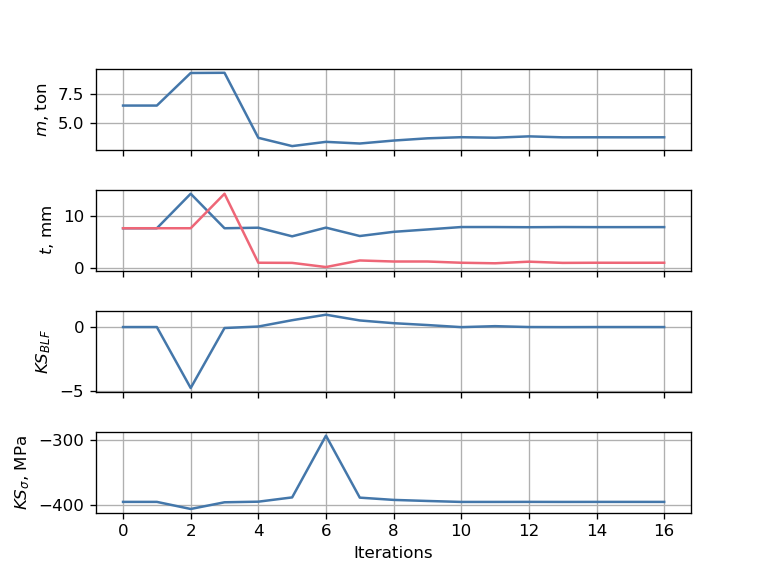

In [38]:
# Instantiate CaseReader object
cr = om.CaseReader(recorder_filepath)

# Get driver cases (do not recurse to system/solver cases) - driver cases represent the snapshots of all the variable values, metadata, and options of the model
driver_cases = cr.get_cases('driver', recurse=False)

# Retrieve the optimization history in terms of objective, design variable and constraints
keys = ['sol_105.mass', 'interp.t_cp', 'sol_105.ks_buckling', 'sol_105.ks_stress']  # keys of the functions to retrieve
histories = {key: np.array([case[key] for case in driver_cases]) for key in keys}  # retrieve histories of the functions

# Print mass percentage variation w.r.t. initial design and final value of thickness and constraints
mass_percentage_variation = (histories['sol_105.mass'][-1, 0]/mass_0 - 1)*100
print(f"""Mass variation: {mass_percentage_variation:.2f} %
Final thickness vector [mm]:""")
print(histories['interp.t_cp'][-1])
print(f"""Final KS value of buckling load factor: {histories['sol_105.ks_buckling'][-1, 0]:.2f}
Final KS value for stress: {histories['sol_105.ks_stress'][-1, 0]:.2f} MPa""")

# Create figure with five subplots sharing the x-axis
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)

# Plot mass history
iterations_array = np.arange(len(histories['sol_105.mass']))
ax1.plot(iterations_array, histories['sol_105.mass'])
ax1.set(ylabel="$m$, ton")
ax1.grid()

# Plot thickness history
ax2.plot(iterations_array, histories['interp.t_cp'])
ax2.set(ylabel="$t$, mm")
ax2.grid()

# Plot nonlinear structural stability KS function history
ax3.plot(iterations_array, histories['sol_105.ks_buckling'])
ax3.set(ylabel="$KS_{BLF}$")
ax3.grid()

# Plot stress KS function history
ax4.plot(iterations_array, histories['sol_105.ks_stress'])
ax4.set(xlabel="Iterations", ylabel="$KS_{\sigma}$, MPa")
ax4.grid()

# Show plot
plt.show()

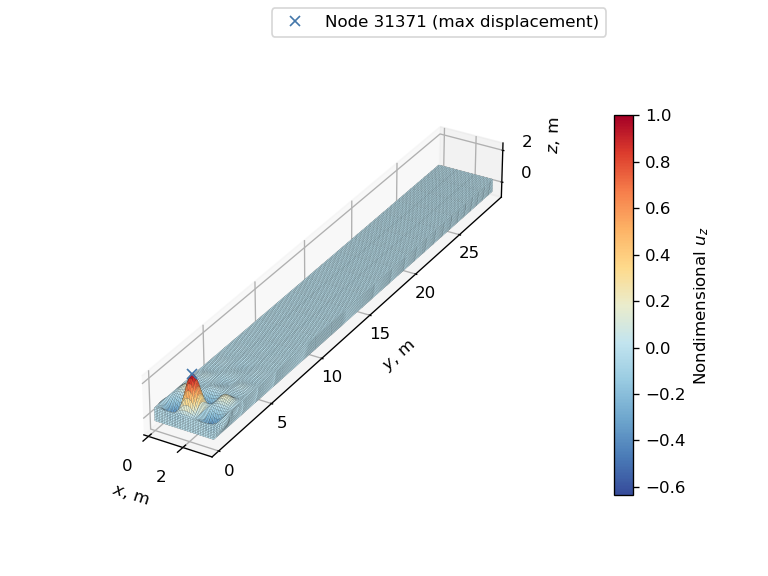

In [39]:
# Read op2 file of linear buckling analysis
sol_105_op2_filepath = os.path.join(ANALYSIS_DIRECTORY_PATH, SOL_105_INPUT_NAME + '.op2')
sol_105_op2 = read_op2(op2_filename=sol_105_op2_filepath, load_geometry=True, debug=None)

# Find node where max displacement occurs
max_displacement_index = np.argmax(np.linalg.norm(sol_105_op2.eigenvectors[SECOND_SUBCASE_ID].data[0, :, 0:3], axis=1))  # find index of max displacement magnitude
max_displacement_node_id = sol_105_op2.eigenvectors[SECOND_SUBCASE_ID].node_gridtype[max_displacement_index, 0]

# Plot buckling mode
amplification_factor = 2  # amplification factor for displacements
_, ax, cbar = pynastran_utils.plot_buckling_mode(op2_object=sol_105_op2, subcase_id=SECOND_SUBCASE_ID,
                                                 displacement_component='tz', colormap='sunset', length_unit='m',
                                                 displacement_amplification_factor=amplification_factor,
                                                 unit_scale_factor=1e-3)  # plot buckling mode converting from mm to m

# Plot node
max_displacement_node_xyz = sol_105_op2.nodes[max_displacement_node_id].xyz*1e-3 + sol_105_op2.eigenvectors[
    SECOND_SUBCASE_ID].data[0, max_displacement_index, 0:3]*amplification_factor  # add displacement to node position and convert to m
ax.plot(max_displacement_node_xyz[0], max_displacement_node_xyz[1], max_displacement_node_xyz[2], 'x',
        label=f"Node {max_displacement_node_id:d} (max displacement)", zorder=4)
ax.legend()

# Adjust plot and show
adjust_3d_plot(ax, cbar)
plt.show()

### Nonlinear response of linearly optimized structure <a name="elliptical-load-nonlinear"></a>

In [40]:
SOL_106_INPUT_NAME = 'box_beam_sol_106'  # default name of the bdf file for the nonlinear analysis

class Sol106Comp(om.ExplicitComponent):
    """
    A component for evaluating the objective and constraints value of the box beam model using SOL 106.

    This component takes as input the wall thickness of the box beam and evaluates the mass of the model.
    It also calculates the value of the nonlinear structural stability, strength and load constraint.

    Attributes
    ----------
    options : dict
        A dictionary of options for the component.

    Methods
    -------
    initialize()
        Declare options for the component.
    setup()
        Define the component's inputs and outputs.
    setup_partials()
        Declare partial derivatives for the component.
    compute(inputs, outputs, discrete_inputs, discrete_outputs)
        Run SOL 106 and calculate output functions.
    compute_ks_function(g, rho=100, upper=0, lower_flag=False)
        Compute the value of the KS function for a given array of constraints.
    """

    def initialize(self):
        """
        Declare options for the component.

        Options
        -------
        bdf_object : BDF
            The BDF object representing the model.
        """
        self.options.declare('bdf_object', types=BDF)
        self.options.declare('upper_eig', types=float, default=UPPER_EIGENVALUE)  # default upper bound for eigenvalues of tangent stiffness matrix [N/mm] - set to 10^4 N/m

    def setup(self):
        """
        Define the component's inputs and outputs.

        Inputs
        ------
        t : float
            Wall thickness.
        input_name : str, discrete
            Name of the input for the analysis.
        run_flag : bool, discrete
            Flag to indicate if the analysis should be run.

        Outputs
        -------
        mass : float
            Mass of the model.
        ks_stress : float
            Von Mises stress aggregated with KS function.
        ks_stability : float
            Lowest eigenvalues of the tangent stiffness matrix aggregated with KS function.
        applied_load : float
            Final applied load in the analysis.
        op2 : OP2, discrete
            OP2 object of the analysis.
        """
        self.add_input('t', shape_by_conn=True)
        self.add_discrete_input('input_name', val=SOL_106_INPUT_NAME)
        self.add_discrete_input('run_flag', val=True)
        self.add_output('mass')
        self.add_output('ks_stress')
        self.add_output('ks_stability')
        self.add_output('applied_load')
        self.add_discrete_output('op2', val=None)

    def setup_partials(self):
        """
        Declare partial derivatives for the component using finite difference method.
        """
        # Finite difference all partials
        self.declare_partials('*', '*', method='fd', step=1e-6)

    def compute(self, inputs, outputs, discrete_inputs, discrete_outputs):
        """
        Assign wall thickness value, run SOL 106 and calculate output functions.

        Parameters
        ----------
        inputs : dict
            Dictionary containing the input values.
        outputs : dict
            Dictionary containing the output values.
        discrete_inputs : dict
            Dictionary containing the discrete input values.
        discrete_outputs : dict
            Dictionary containing the discrete output values.
        """
        # Assign component options
        bdf_object = self.options['bdf_object']
        upper_eig = self.options['upper_eig']
        # Assign thicknesses to PSHELL cards
        for i, pid in enumerate(bdf_object.properties):
            bdf_object.properties[pid].t = inputs['t'][0, i]
            bdf_object.properties[pid].z1 = -inputs['t'][0, i]/2
            bdf_object.properties[pid].z2 = inputs['t'][0, i]/2
        # Calculate mass
        outputs['mass'] = mass_properties(bdf_object)[0]
        # Run SOL 106 and return OP2 object as discrete output
        input_name = discrete_inputs['input_name']
        run_flag = discrete_inputs['run_flag']
        sol_106_op2 = pynastran_utils.run_tangent_stiffness_matrix_eigenvalue_calculation(bdf_object=bdf_object.__deepcopy__({}),
                                                                                          method_set_id=METHOD_SET_ID,
                                                                                          no_eigenvalues=NO_EIGENVALUES,
                                                                                          analysis_directory_path=ANALYSIS_DIRECTORY_PATH,
                                                                                          input_name=input_name, upper_eig=UPPER_EIGENVALUE,
                                                                                          run_flag=run_flag)
        discrete_outputs['op2'] = sol_106_op2
        # Read eigenvalues of tangent stiffness matrix and aggregate with KS function
        f06_filepath = os.path.join(ANALYSIS_DIRECTORY_PATH, input_name + '.f06')  # path to .f06 file
        eigenvalues = pynastran_utils.read_kllrh_lowest_eigenvalues_from_f06(f06_filepath)  # read eigenvalues from f06 files
        outputs['ks_stability'] = self.compute_ks_function(eigenvalues[~np.isnan(eigenvalues)].flatten()*1e3, lower_flag=True)  # eigenvalues are converted from N/mm to N/m
        # Find von mises stresses and aggregate with KS function
        stresses = sol_106_op2.nonlinear_cquad4_stress[FIRST_SUBCASE_ID].data[-1, :, 5]
        outputs['ks_stress'] = self.compute_ks_function(stresses, upper=SIGMA_Y)
        # Find final applied load in the analysis
        _, applied_loads, _ = pynastran_utils.read_load_displacement_history_from_op2(op2_object=sol_106_op2)
        outputs['applied_load'] = applied_loads[FIRST_SUBCASE_ID][-1, Z_AXIS_INDEX]  # read load along z-axis at last converged iteration
    
    @staticmethod
    def compute_ks_function(g, rho=100, upper=0, lower_flag=False):
        """
        Compute the value of the KS function for the given array of constraints.

        Parameters
        ----------
        g : ndarray
            Array of constraint values. By default negative means satisfied and positive means violated. Behavior is modified with upper and lower_flag.
        rho : float, optional
            Constraint aggregation factor. Default is 100.
        upper : float, optional
            Upper bound for the constraints. If lower_flag is True, then this is the lower bound. Default is 0.
        lower_flag : bool, optional
            Flag to indicate if the constraints are lower-bounded. Default is False.

        Returns
        -------
        float
            Value of KS function.
        """
        con_val = g - upper  # subtract upper bound
        if lower_flag:
            con_val = -con_val  # negate if constraint is lower-bounded
        g_max = np.max(np.atleast_2d(con_val), axis=-1)[:, np.newaxis]  # find maximum constraint value
        g_diff = con_val - g_max  # subtract maximum constraint value
        exponents = np.exp(rho * g_diff)  # exponentiate
        summation = np.sum(exponents, axis=-1)[:, np.newaxis]  # sum exponentiated values
        KS = g_max + 1.0 / rho * np.log(summation)  # compute KS function
        return KS

In [41]:
class BoxBeamNonlinearGroup(om.Group):
    """
    A group representing a system setup for the nonlinear analysis and optimization of a box beam model.

    This group is designed for the analysis and the mass minimization of a box beam model, 
    subject to KS aggregated von Mises stress and structural stability constraints. 
    It incorporates the Sol106Comp component to achieve this.

    Attributes
    ----------
    options : dict
        A dictionary of options for the group.

    Methods
    -------
    initialize()
        Declare options for the group.
    setup()
        Define the group's components and their interconnections.
    """

    def initialize(self):
        """
        Declare options for the group.

        Options
        -------
        bdf_object : BDF
            The BDF object representing the box beam model.
        """
        self.options.declare('bdf_object', BDF)

    def setup(self):
        """
        Define the group's components and their interconnections.

        The method sets up the Sol106Comp component within the group using the provided box beam model.
        """
        bdf_object = self.options['bdf_object']  # assign group options
        comp = Sol106Comp(bdf_object=bdf_object)  # create SOL 106 component
        self.add_subsystem('sol_106', comp)  # add SOL 106 component to the group

In [42]:
box_beam_bdf.case_control_deck.subcases[0].params['NLSTRESS'] = box_beam_bdf.case_control_deck.subcases[0].params.pop('STRESS')  # change stress output to nonlinear stresses
pynastran_utils.set_up_arc_length_method(bdf_object=box_beam_bdf, max_iter=3, conv='PU', eps_p=1e-5, eps_u=1e-5, max_bisect=20,
                                         minalr=1e-5, desiter=3, maxinc=2000)
pynastran_utils.create_static_load_subcase(bdf_object=box_beam_bdf, subcase_id=FIRST_SUBCASE_ID, load_set_id=LOAD_SET_ID)
box_beam_bdf.load_combinations[LOAD_SET_ID][0].scale_factors[0] = design_load*2  # scale load to twice the design load

In [43]:
box_beam_nonlinear = BoxBeamNonlinearGroup(bdf_object=box_beam_bdf.__deepcopy__({}))
box_beam_nonlinear.add_subsystem('interp', interp_comp)  # add spline component to the group
box_beam_nonlinear.connect('interp.t_val', 'sol_106.t')  # connect spline component output to the SOL 105 component input
nonlinear_problem = om.Problem(model=box_beam_nonlinear)
nonlinear_problem.setup()
nonlinear_problem.set_val('interp.t_cp', histories['interp.t_cp'][-1])
input_name = "linear_opt_sol_106"
nonlinear_problem.set_val('sol_106.input_name', input_name)
nonlinear_problem.set_val('sol_106.run_flag', True)
nonlinear_problem.run_model()

Nastran job linear_opt_sol_106.bdf completed
Wall time: 17726.0 s


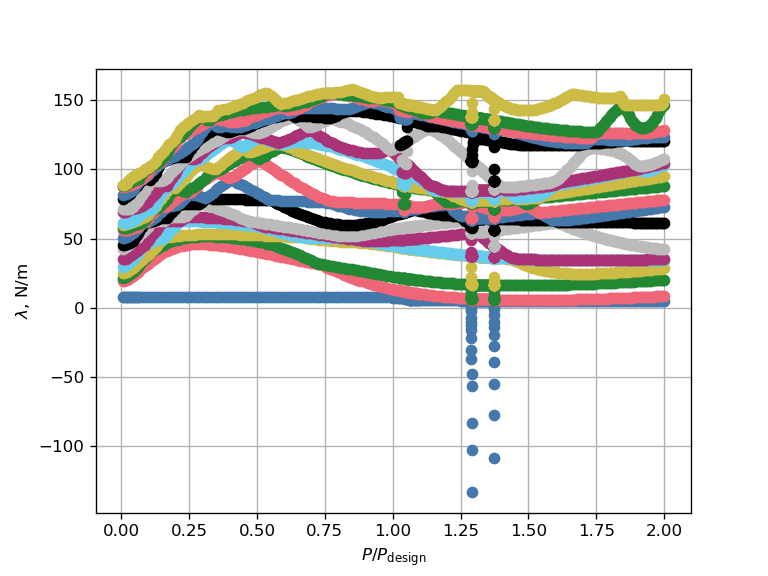

In [44]:
# Retrieve OP2 object of nonlinear analysis
sol_106_op2 = nonlinear_problem['sol_106.op2']

# Read load and displacement history of benchmark analysis from op2 file
_, applied_loads, _ = pynastran_utils.read_load_displacement_history_from_op2(op2_object=sol_106_op2)

# Read eigenvalues of tangent stiffness matrix
f06_path = os.path.join(ANALYSIS_DIRECTORY_PATH, input_name + '.f06')  # path to .f06 file
eigenvalues = pynastran_utils.read_kllrh_lowest_eigenvalues_from_f06(f06_path)

# Plot eigenvalues vs applied load
_, ax = plt.subplots()
ax.plot(applied_loads[FIRST_SUBCASE_ID][:, Z_AXIS_INDEX]/design_load, eigenvalues.T*1e3, 'o')  # convert eigenvalues from N/mm to N/m
ax.set_ylabel("$\lambda$, N/m")
ax.set_xlabel("$P/P_\mathrm{design}$")
ax.grid(visible=True)
plt.show()

### Nonlinear structural stability optimization <a name="elliptical-load-nonlinear"></a>

In [45]:
nonlinear_problem.model.sol_106.options['bdf_object'].nlpcis[1].mxinc = 300
nonlinear_problem.model.sol_106.options['bdf_object'].load_combinations[LOAD_SET_ID][0].scale_factors[0] = design_load  # scale load to design load

In [46]:
input_name = 'nonlinear_opt_sol_106_start'
nonlinear_problem.set_val('sol_106.input_name', input_name)
nonlinear_problem.set_val('sol_106.run_flag', True)
nonlinear_problem.run_model()
mass_0 = nonlinear_problem['sol_106.mass'][0]
ks_stability_0 = nonlinear_problem["sol_106.ks_stability"][0]
ks_stress_0 = nonlinear_problem["sol_106.ks_stress"][0]
print(f"""Initial mass: {mass_0*1e3:.0f} kg
Initial KS value for stability: {ks_stability_0:.1f} N/m
Initial KS value for stress: {ks_stress_0:.0f} MPa""")

Nastran job nonlinear_opt_sol_106_start.bdf completed
Wall time: 4032.0 s


Initial mass: 3767 kg
Initial KS value for stability: -7.3 N/m
Initial KS value for stress: -395 MPa


In [47]:
# Set default input values of sol_106 component
nonlinear_problem.model.set_input_defaults('interp.t_cp', histories['interp.t_cp'][-1])
nonlinear_problem.model.set_input_defaults('sol_106.input_name', 'nonlinear_opt_sol_106')
nonlinear_problem.model.set_input_defaults('sol_106.run_flag', True)

# Choose optimizer
nonlinear_problem.driver = om.ScipyOptimizeDriver()
nonlinear_problem.driver.options['optimizer'] = 'COBYLA'
nonlinear_problem.driver.options['tol'] = 1e-3

# Add design variable, objective and constraints
nonlinear_problem.model.add_design_var('interp.t_cp', lower=thickness_bounds[0], upper=thickness_bounds[1], ref0=thickness_bounds[0], ref=t0)  # scale thickness so that the lower bound is 0 and initial value is 1
nonlinear_problem.model.add_objective('sol_106.mass', ref0=mass_0/2, ref=mass_0)  # scale mass so that half of the initial mass is 0 and the initial mass is 1
nonlinear_problem.model.add_constraint('sol_106.ks_stability', upper=0., ref=np.abs(ks_stability_0))  # scale KS function for nonlinear structural stability so that the initial value is 1
nonlinear_problem.model.add_constraint('sol_106.ks_stress', upper=0., ref=np.abs(ks_stress_0))  # scale KS function for stresses so that the initial value is 1
nonlinear_problem.model.add_constraint('sol_106.applied_load', lower=design_load*.99, ref=design_load)  # scale applied load so that design

In [48]:
recorder_filepath = os.path.join(ANALYSIS_DIRECTORY_PATH, 'sol_106_optimization.sql')
recorder = om.SqliteRecorder(recorder_filepath)  # create recorder
nonlinear_problem.driver.add_recorder(recorder)  # attach recorder to the driver

In [49]:
nonlinear_problem.setup()  # re-setup problem
nonlinear_problem.set_solver_print(0)  # disable solver output
nonlinear_problem.driver.options['debug_print'] = ['desvars','nl_cons','objs']  # print design variables, constraints and objectives
if True:  # set True or False to run optimization or not
    nonlinear_problem.run_driver()  # run optimization
nonlinear_problem.cleanup()  # clean up problem

c:\Users\qa21944\Anaconda3\envs\phd-notebooks\lib\site-packages\openmdao\recorders\sqlite_recorder.py:227: UserWarning:The existing case recorder file, c:\Users\qa21944\Github\phd-jupyter-notebooks\notebooks\analyses\21_Optimization_of_the_CRM-like_Box_Beam_with_Distributed_Load\sol_106_optimization.sql, is being overwritten.


Driver debug print for iter coord: rank0:ScipyOptimize_COBYLA|0
---------------------------------------------------------------
Design Vars
{'interp.t_cp': array([[7.9, 1. ]])}

Nastran job box_beam_sol_106.bdf completed
Wall time: 4010.0 s


Nonlinear constraints
{'sol_106.applied_load': array([30437.9]),
 'sol_106.ks_stability': array([-7.3]),
 'sol_106.ks_stress': array([-395.4])}

Objectives
{'sol_106.mass': array([3.8])}

Driver debug print for iter coord: rank0:ScipyOptimize_COBYLA|1
---------------------------------------------------------------
Design Vars
{'interp.t_cp': array([[7.9, 1. ]])}



Mass variation: -12.4 %
Final thickness vector [mm]:
[6.8 1. ]
Final KS value of nonlinear structural stability: -8.32 N/m
Final KS value for stress: -382 MPa


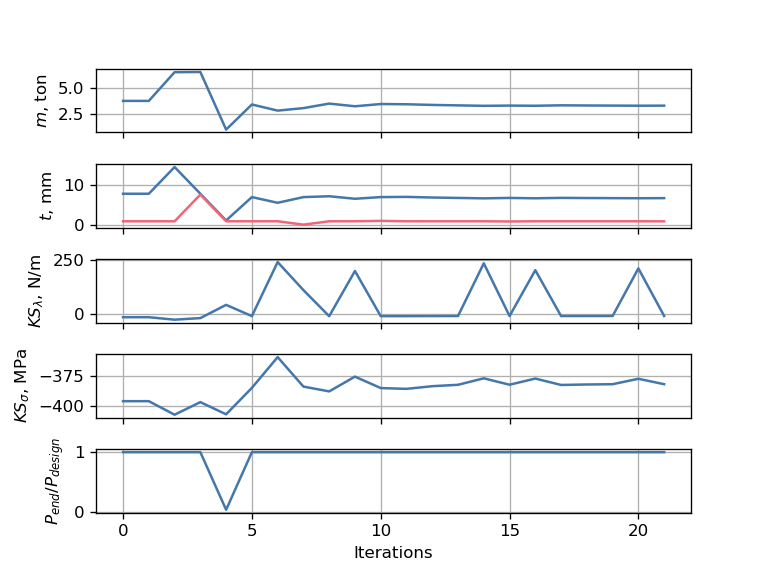

In [ ]:
# Instantiate CaseReader object
cr = om.CaseReader(recorder_filepath)

# Get driver cases (do not recurse to system/solver cases) - driver cases represent the snapshots of all the variable values, metadata, and options of the model
driver_cases = cr.get_cases('driver', recurse=False)

# Retrieve the optimization history in terms of objective, design variable and constraints
keys = ['sol_106.mass', 'interp.t_cp', 'sol_106.ks_stability', 'sol_106.ks_stress', 'sol_106.applied_load']  # keys of the functions to retrieve
histories = {key: np.array([case[key] for case in driver_cases]) for key in keys}  # retrieve histories of the functions

# Find last index where stability constraint is satisfied
stability_constraint_satisfied = histories['sol_106.ks_stability'][:, 0] <= 0
final_design_index = np.where(stability_constraint_satisfied)[0][-1]

# Print mass percentage variation w.r.t. initial design and final value of thickness and constraints
mass_percentage_variation = (histories['sol_106.mass'][final_design_index, 0]/mass_0 - 1)*100
print(f"""Mass variation: {mass_percentage_variation:.1f} %
Final thickness vector [mm]:""")
print(histories['interp.t_cp'][final_design_index])
print(f"""Final KS value of nonlinear structural stability: {histories["sol_106.ks_stability"][final_design_index, 0]:.2f} N/m
Final KS value for stress: {histories['sol_106.ks_stress'][final_design_index, 0]:.0f} MPa""")

# Create figure with five subplots sharing the x-axis
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, sharex=True)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)

# Plot mass history
iterations_array = np.arange(len(histories['sol_106.mass'][:final_design_index + 1]))
ax1.plot(iterations_array, histories['sol_106.mass'][:final_design_index + 1, 0])
ax1.set(ylabel="$m$, ton")
ax1.grid()

# Plot thickness history
ax2.plot(iterations_array, histories['interp.t_cp'][:final_design_index + 1, 0])
ax2.plot(iterations_array, histories['interp.t_cp'][:final_design_index + 1, 1])
ax2.set(ylabel="$t$, mm")
ax2.grid()

# Plot nonlinear structural stability KS function history
ax3.plot(iterations_array, histories['sol_106.ks_stability'][:final_design_index + 1, 0])
ax3.set(ylabel="$KS_{\lambda}$, N/m")
ax3.grid()

# Plot stress KS function history
ax4.plot(iterations_array, histories['sol_106.ks_stress'][:final_design_index + 1, 0])
ax4.set(ylabel="$KS_{\sigma}$, MPa")
ax4.grid()

# Plot applied load history
ax5.plot(iterations_array, histories['sol_106.applied_load'][:final_design_index + 1, 0]/design_load)
ax5.set(xlabel='Iterations', ylabel="$P_{end}/P_{design}$")
ax5.grid()

# Show plot
plt.show()